In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 7)

# Scikit-Learn ≥ 1.0.1 is required
from packaging import version
import sklearn
print(sklearn.__version__)
assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

# Common imports
import numpy as np
import pandas as pd
import os

# To plot pretty figures
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# To save models
from joblib import dump

1.4.1.post1


## Loading the data

In [2]:
# weather data
weather = pd.read_csv('data/weather.csv')
# keep only useful columns
columns = ["timestamp", "temp", "pressure", "cloudiness", "humidity_relative"]
weather = weather[columns]
weather.head()

,timestamp,temp,pressure,cloudiness,humidity_relative
0,2023-03-01T09:00:00,4.9,1029.7,0.0,54.3
1,2023-03-01T09:00:00,2.1,1029.3,NaN,73.7
2,2023-03-01T09:00:00,3.3,1029.6,1.0,NaN
3,2023-03-01T09:00:00,1.6,1029.4,NaN,70.9
4,2023-03-01T10:00:00,3.0,1028.8,NaN,60.8


In [3]:
# sunrise-sunset data
sun = pd.read_excel('data/sunrise-sunset.xlsx')
sun.head()

,datum,Opkomst,Op ware middag,Ondergang
0,2023-01-01,08:45:00,12:46:00,16:47:00
1,2023-01-02,08:45:00,12:46:00,16:48:00
2,2023-01-03,08:45:00,12:47:00,16:49:00
3,2023-01-04,08:44:00,12:47:00,16:51:00
4,2023-01-05,08:44:00,12:48:00,16:52:00


In [4]:
# solar data
solar = pd.read_csv('data/solar.csv')
solar.head()

,timestamp,kwh
0,2023-03-11 16:00:10.160454+01,0.54
1,2023-03-11 17:00:10.217795+01,1.02
2,2023-03-11 18:00:10.284064+01,1.17
3,2023-03-11 19:00:10.224836+01,1.18
4,2023-03-11 20:00:10.201847+01,1.18


## Take a quick look at the data structure of every data set

### weather

In [5]:
weather.head()

,timestamp,temp,pressure,cloudiness,humidity_relative
0,2023-03-01T09:00:00,4.9,1029.7,0.0,54.3
1,2023-03-01T09:00:00,2.1,1029.3,NaN,73.7
2,2023-03-01T09:00:00,3.3,1029.6,1.0,NaN
3,2023-03-01T09:00:00,1.6,1029.4,NaN,70.9
4,2023-03-01T10:00:00,3.0,1028.8,NaN,60.8


Observation:
- one row in every four rows in the data set represents the measurements of one weahter station at one timestamp

In [6]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39840 entries, 0 to 39839
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   timestamp          39840 non-null  object 
 1   temp               39840 non-null  float64
 2   pressure           39828 non-null  float64
 3   cloudiness         15455 non-null  float64
 4   humidity_relative  29880 non-null  float64
dtypes: float64(4), object(1)
memory usage: 1.5+ MB


Observation:
- cloudiness and humidity_relative have a lot of null values

In [7]:
weather.describe()

,temp,pressure,cloudiness,humidity_relative
count,39840.000000,39828.000000,15455.000000,29880.000000
mean,11.857083,1013.377732,5.490780,81.043618
std,5.858675,11.320142,2.583189,13.898511
min,-5.900000,965.100000,0.000000,24.700000
25%,8.200000,1007.200000,4.000000,72.500000
50%,11.200000,1014.700000,7.000000,84.200000
75%,15.900000,1021.200000,7.000000,92.000000
max,32.400000,1041.800000,8.000000,100.000000


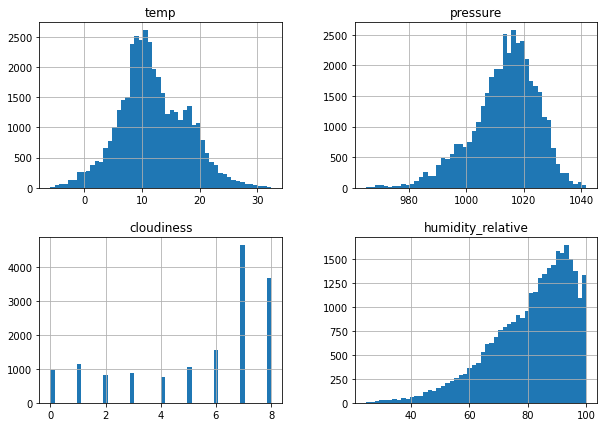

In [8]:
weather.hist(bins=50, figsize=(10,7))
plt.show()

Observations:
- cloudiness is categorical
- humidity_relative looks capped at 100

### solar

In [9]:
solar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9705 entries, 0 to 9704
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  9705 non-null   object 
 1   kwh        9705 non-null   float64
dtypes: float64(1), object(1)
memory usage: 151.8+ KB


In [10]:
solar.describe()

,kwh
count,9705.000000
mean,1401.190049
std,741.801205
min,0.000000
25%,772.572600
50%,1737.388200
75%,1964.015800
max,2417.478800


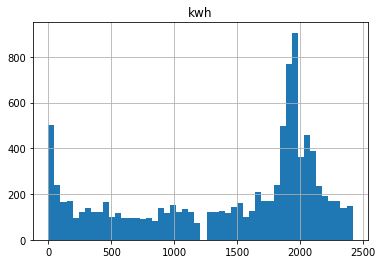

In [11]:
solar.hist(bins=50, figsize=(6, 4))
plt.show()

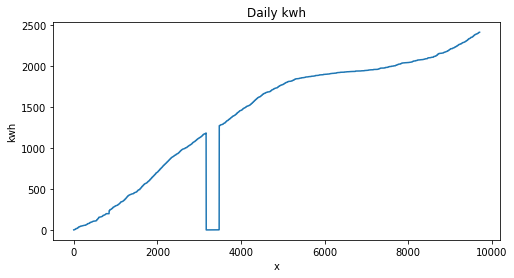

In [12]:
# plot kwh
plt.figure(figsize=(8, 4))
plt.plot(solar["kwh"])
plt.xlabel("x")
plt.ylabel("kwh")
plt.title("Daily kwh")
plt.show()

Observations:
- kwh is a cumulative value
- there are outliers

### sunrise-sunset

In [13]:
sun.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   datum           731 non-null    datetime64[ns]
 1   Opkomst         731 non-null    object        
 2   Op ware middag  731 non-null    object        
 3   Ondergang       731 non-null    object        
dtypes: datetime64[ns](1), object(3)
memory usage: 23.0+ KB


In [14]:
sun[["Opkomst", "Op ware middag", "Ondergang"]].describe()

,Opkomst,Op ware middag,Ondergang
count,731,731,731
unique,195,56,283
top,05:29:00,13:39:00,16:37:00
freq,24,51,20


### merge weahter and solar datasets into one

In [15]:
print(len(weather))
weather = weather.groupby("timestamp").mean().reset_index()
print(len(weather))

39840
9960


In [16]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9960 entries, 0 to 9959
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   timestamp          9960 non-null   object 
 1   temp               9960 non-null   float64
 2   pressure           9960 non-null   float64
 3   cloudiness         9960 non-null   float64
 4   humidity_relative  9960 non-null   float64
dtypes: float64(4), object(1)
memory usage: 389.2+ KB


In [17]:
weather["timestamp"] = pd.to_datetime(weather["timestamp"], utc=True)
solar["timestamp"] = pd.to_datetime(solar["timestamp"], utc=True)

In [18]:
data = pd.merge_asof(solar, weather, on="timestamp", direction="nearest")

In [19]:
data.shape

(9705, 6)

In [20]:
data.head()

,timestamp,kwh,temp,pressure,cloudiness,humidity_relative
0,2023-03-11 15:00:10.160454+00:00,0.54,6.85,1012.025,6.0,54.833333
1,2023-03-11 16:00:10.217795+00:00,1.02,6.30,1011.625,7.0,57.800000
2,2023-03-11 17:00:10.284064+00:00,1.17,5.95,1011.500,7.0,60.366667
3,2023-03-11 18:00:10.224836+00:00,1.18,5.25,1011.850,7.0,64.500000
4,2023-03-11 19:00:10.201847+00:00,1.18,4.85,1011.650,7.0,68.633333


In [21]:
# clean weather timestamp data
data["timestamp"] = data["timestamp"].apply(lambda date: pd.to_datetime(date).strftime("%Y-%m-%d %H"))
# split timestamp into date and hour
data["date"] = data["timestamp"].apply(lambda date: date.split(" ")[0])
data["hour"] = data["timestamp"].apply(lambda date: date.split(" ")[1]).astype(int)
data.drop(columns=["timestamp"], inplace=True)
data.head()

,kwh,temp,pressure,cloudiness,humidity_relative,date,hour
0,0.54,6.85,1012.025,6.0,54.833333,2023-03-11,15
1,1.02,6.30,1011.625,7.0,57.800000,2023-03-11,16
2,1.17,5.95,1011.500,7.0,60.366667,2023-03-11,17
3,1.18,5.25,1011.850,7.0,64.500000,2023-03-11,18
4,1.18,4.85,1011.650,7.0,68.633333,2023-03-11,19


In [22]:
sun.rename(columns={"datum": "date", "Opkomst": "sunrise", "Op ware middag": "sun_noon", "Ondergang": "sunset"}, inplace=True)
# make date column a string
sun["date"] = sun["date"].apply(lambda date: date.strftime("%Y-%m-%d"))
sun.head()

,date,sunrise,sun_noon,sunset
0,2023-01-01,08:45:00,12:46:00,16:47:00
1,2023-01-02,08:45:00,12:46:00,16:48:00
2,2023-01-03,08:45:00,12:47:00,16:49:00
3,2023-01-04,08:44:00,12:47:00,16:51:00
4,2023-01-05,08:44:00,12:48:00,16:52:00


In [23]:
# merge all data
data = data.merge(sun, on=["date"], how="inner")
print(data.shape)

(9705, 10)


In [24]:
data.head()

,kwh,temp,pressure,cloudiness,humidity_relative,date,hour,sunrise,sun_noon,sunset
0,0.54,6.85,1012.025,6.0,54.833333,2023-03-11,15,07:06:00,12:53:00,18:40:00
1,1.02,6.30,1011.625,7.0,57.800000,2023-03-11,16,07:06:00,12:53:00,18:40:00
2,1.17,5.95,1011.500,7.0,60.366667,2023-03-11,17,07:06:00,12:53:00,18:40:00
3,1.18,5.25,1011.850,7.0,64.500000,2023-03-11,18,07:06:00,12:53:00,18:40:00
4,1.18,4.85,1011.650,7.0,68.633333,2023-03-11,19,07:06:00,12:53:00,18:40:00


## Cleaning the data

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9705 entries, 0 to 9704
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   kwh                9705 non-null   float64
 1   temp               9705 non-null   float64
 2   pressure           9705 non-null   float64
 3   cloudiness         9705 non-null   float64
 4   humidity_relative  9705 non-null   float64
 5   date               9705 non-null   object 
 6   hour               9705 non-null   int32  
 7   sunrise            9705 non-null   object 
 8   sun_noon           9705 non-null   object 
 9   sunset             9705 non-null   object 
dtypes: float64(5), int32(1), object(4)
memory usage: 796.1+ KB


In [26]:
data["date"] = pd.to_datetime(data["date"])

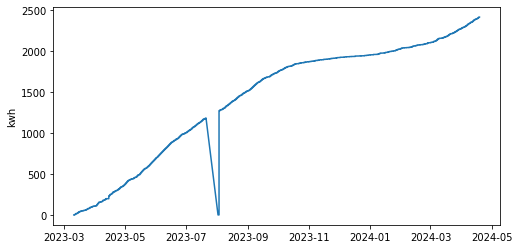

In [27]:
# plot kwh
plt.figure(figsize=(8, 4))
plt.plot(data["date"], data["kwh"])
plt.ylabel("kwh")
plt.show()

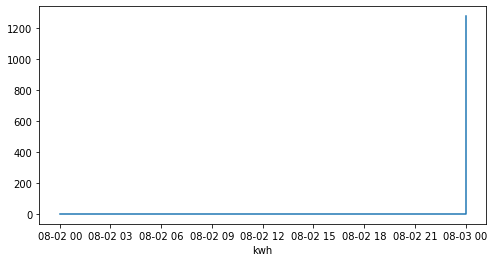

In [28]:
# plot kwh outliers
outliers = data[(data["date"] == "2023-08-02") | (data["date"] == "2023-08-03")]
plt.figure(figsize=(8, 4))
plt.plot(outliers["date"], outliers["kwh"])
plt.xlabel("kwh")
plt.show()

In [29]:
# remove outliers
print(data.shape)
data = data[(data["date"] != "2023-08-02") & (data["date"] != "2023-08-03")]
print(data.shape)

(9705, 10)
(9382, 10)


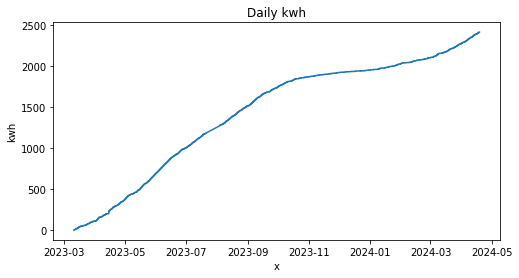

In [30]:
# plot kwh
plt.figure(figsize=(8, 4))
plt.plot(data["date"], data["kwh"])
plt.xlabel("x")
plt.ylabel("kwh")
plt.title("Daily kwh")
plt.show()

In [31]:
# kwh is cummulative, make it hourly
data["kwh"] = data["kwh"] - data["kwh"].shift(1, fill_value=0)
data.head()

,kwh,temp,pressure,cloudiness,humidity_relative,date,hour,sunrise,sun_noon,sunset
0,0.54,6.85,1012.025,6.0,54.833333,2023-03-11,15,07:06:00,12:53:00,18:40:00
1,0.48,6.30,1011.625,7.0,57.800000,2023-03-11,16,07:06:00,12:53:00,18:40:00
2,0.15,5.95,1011.500,7.0,60.366667,2023-03-11,17,07:06:00,12:53:00,18:40:00
3,0.01,5.25,1011.850,7.0,64.500000,2023-03-11,18,07:06:00,12:53:00,18:40:00
4,0.00,4.85,1011.650,7.0,68.633333,2023-03-11,19,07:06:00,12:53:00,18:40:00


<Axes: ylabel='kwh'>

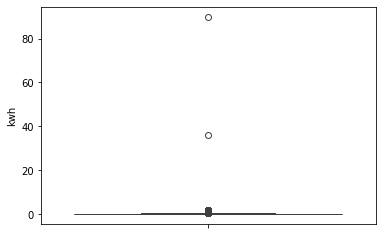

In [32]:
sns.boxplot(data["kwh"])

Observation:
- there are still outliers

In [33]:
def remove_outliers(df, col):
    mean = df[col].mean()
    std = data[col].std()
    return df[abs(df[col] - mean) < 3 * std]

In [34]:
print(data["kwh"].mean(), data["kwh"].std())

0.25767201023235975 1.0944543220890077


In [35]:
print(len(data))
# remove outliers
data = remove_outliers(data, "kwh")
print(len(data))
data.describe()

9382
9380


,kwh,temp,pressure,cloudiness,humidity_relative,hour
count,9380.000000,9380.000000,9380.000000,9380.000000,9380.000000,9380.000000
mean,0.244283,11.859731,1013.802559,5.392697,81.024012,11.564286
std,0.450857,5.690816,11.293369,2.422875,12.760237,6.937187
min,0.000000,-4.650000,967.800000,0.000000,31.366667,0.000000
25%,0.000000,8.250000,1007.750000,3.500000,73.366667,6.000000
50%,0.000000,11.150000,1015.475000,6.500000,84.233333,12.000000
75%,0.248600,15.600000,1021.581250,7.000000,91.100000,18.000000
max,2.098000,30.975000,1041.275000,8.000000,99.033333,23.000000


In [36]:
print(data["kwh"].mean(), data["kwh"].std())

0.2442831663113006 0.4508573598238607


In [37]:
data.head()

,kwh,temp,pressure,cloudiness,humidity_relative,date,hour,sunrise,sun_noon,sunset
0,0.54,6.85,1012.025,6.0,54.833333,2023-03-11,15,07:06:00,12:53:00,18:40:00
1,0.48,6.30,1011.625,7.0,57.800000,2023-03-11,16,07:06:00,12:53:00,18:40:00
2,0.15,5.95,1011.500,7.0,60.366667,2023-03-11,17,07:06:00,12:53:00,18:40:00
3,0.01,5.25,1011.850,7.0,64.500000,2023-03-11,18,07:06:00,12:53:00,18:40:00
4,0.00,4.85,1011.650,7.0,68.633333,2023-03-11,19,07:06:00,12:53:00,18:40:00


In [38]:
# get difference in minutes between sunrise and hour (int)
data["sunrise"] = data["sunrise"].apply(lambda time: time.hour * 60 + time.minute)
data["sun_noon"] = data["sun_noon"].apply(lambda time: time.hour * 60 + time.minute)
data["sunset"] = data["sunset"].apply(lambda time: time.hour * 60 + time.minute)
data.head()

,kwh,temp,pressure,cloudiness,humidity_relative,date,hour,sunrise,sun_noon,sunset
0,0.54,6.85,1012.025,6.0,54.833333,2023-03-11,15,426,773,1120
1,0.48,6.30,1011.625,7.0,57.800000,2023-03-11,16,426,773,1120
2,0.15,5.95,1011.500,7.0,60.366667,2023-03-11,17,426,773,1120
3,0.01,5.25,1011.850,7.0,64.500000,2023-03-11,18,426,773,1120
4,0.00,4.85,1011.650,7.0,68.633333,2023-03-11,19,426,773,1120


In [39]:
# the amount of minutes since sunrise at the current hour
data["sunrise_diff"] = data["hour"] * 60 - data["sunrise"]
# the amount of minutes since noon at the current hour
data["sun_noon_diff"] = abs(data["hour"] * 60 - data["sun_noon"])
# the amount of minutes until sunset at the current hour
data["sunset_diff"] =  data["sunset"] - data["hour"] * 60
data.head()

,kwh,temp,pressure,cloudiness,humidity_relative,date,hour,sunrise,sun_noon,sunset,sunrise_diff,sun_noon_diff,sunset_diff
0,0.54,6.85,1012.025,6.0,54.833333,2023-03-11,15,426,773,1120,474,127,220
1,0.48,6.30,1011.625,7.0,57.800000,2023-03-11,16,426,773,1120,534,187,160
2,0.15,5.95,1011.500,7.0,60.366667,2023-03-11,17,426,773,1120,594,247,100
3,0.01,5.25,1011.850,7.0,64.500000,2023-03-11,18,426,773,1120,654,307,40
4,0.00,4.85,1011.650,7.0,68.633333,2023-03-11,19,426,773,1120,714,367,-20


In [40]:
# change timestamps to difference in minutes from minimum timestamp
# data["sunrise"] = data["sunrise"].apply(lambda time: time.hour * 60 + time.minute)
# sunrise_min = data["sunrise"].min()
# data["sunrise"] = data["sunrise"] - sunrise_min

# data["sun_noon"] = data["sun_noon"].apply(lambda time: time.hour * 60 + time.minute)
# sun_noon_min = data["sun_noon"].min()
# data["sun_noon"] = data["sun_noon"] - sun_noon_min

# data["sunset"] = data["sunset"].apply(lambda time: time.hour * 60 + time.minute)
# sunset_min = data["sunset"].min()
# data["sunset"] = data["sunset"] - sunset_min
# data.head()

In [41]:
# add month and day columns
data["month"] = data["date"].dt.month
data["day_of_week"] = data["date"].dt.dayofweek
# drop date column
data.drop("date", axis=1, inplace=True)
# convert hour to int
data["hour"] = data["hour"].astype("int")

## Date exploration

In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9380 entries, 0 to 9704
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   kwh                9380 non-null   float64
 1   temp               9380 non-null   float64
 2   pressure           9380 non-null   float64
 3   cloudiness         9380 non-null   float64
 4   humidity_relative  9380 non-null   float64
 5   hour               9380 non-null   int32  
 6   sunrise            9380 non-null   int64  
 7   sun_noon           9380 non-null   int64  
 8   sunset             9380 non-null   int64  
 9   sunrise_diff       9380 non-null   int64  
 10  sun_noon_diff      9380 non-null   int64  
 11  sunset_diff        9380 non-null   int64  
 12  month              9380 non-null   int64  
 13  day_of_week        9380 non-null   int64  
dtypes: float64(5), int32(1), int64(8)
memory usage: 1.0 MB


In [43]:
data.head()

,kwh,temp,pressure,cloudiness,humidity_relative,hour,sunrise,sun_noon,sunset,sunrise_diff,sun_noon_diff,sunset_diff,month,day_of_week
0,0.54,6.85,1012.025,6.0,54.833333,15,426,773,1120,474,127,220,3,5
1,0.48,6.30,1011.625,7.0,57.800000,16,426,773,1120,534,187,160,3,5
2,0.15,5.95,1011.500,7.0,60.366667,17,426,773,1120,594,247,100,3,5
3,0.01,5.25,1011.850,7.0,64.500000,18,426,773,1120,654,307,40,3,5
4,0.00,4.85,1011.650,7.0,68.633333,19,426,773,1120,714,367,-20,3,5


In [44]:
data.describe()

,kwh,temp,pressure,cloudiness,humidity_relative,hour,sunrise,sun_noon,sunset,sunrise_diff,sun_noon_diff,sunset_diff,month,day_of_week
count,9380.000000,9380.000000,9380.000000,9380.000000,9380.000000,9380.000000,9380.000000,9380.000000,9380.000000,9380.000000,9380.000000,9380.000000,9380.000000,9380.000000
mean,0.244283,11.859731,1013.802559,5.392697,81.024012,11.564286,430.646269,797.001706,1163.487100,263.210874,368.636674,469.629957,6.184009,3.002132
std,0.450857,5.690816,11.293369,2.422875,12.760237,6.937187,60.713691,28.942723,108.579749,420.689035,220.749690,429.904640,3.456281,2.004153
min,0.000000,-4.650000,967.800000,0.000000,31.366667,0.000000,329.000000,746.000000,997.000000,-525.000000,3.000000,-383.000000,1.000000,0.000000
25%,0.000000,8.250000,1007.750000,3.500000,73.366667,6.000000,387.000000,771.000000,1059.000000,-98.000000,184.000000,105.000000,3.000000,1.000000
50%,0.000000,11.150000,1015.475000,6.500000,84.233333,12.000000,431.000000,812.000000,1161.000000,264.000000,365.000000,468.000000,6.000000,3.000000
75%,0.248600,15.600000,1021.581250,7.000000,91.100000,18.000000,484.000000,823.000000,1258.000000,626.000000,536.000000,831.000000,9.000000,5.000000
max,2.098000,30.975000,1041.275000,8.000000,99.033333,23.000000,525.000000,829.000000,1320.000000,1051.000000,829.000000,1320.000000,12.000000,6.000000


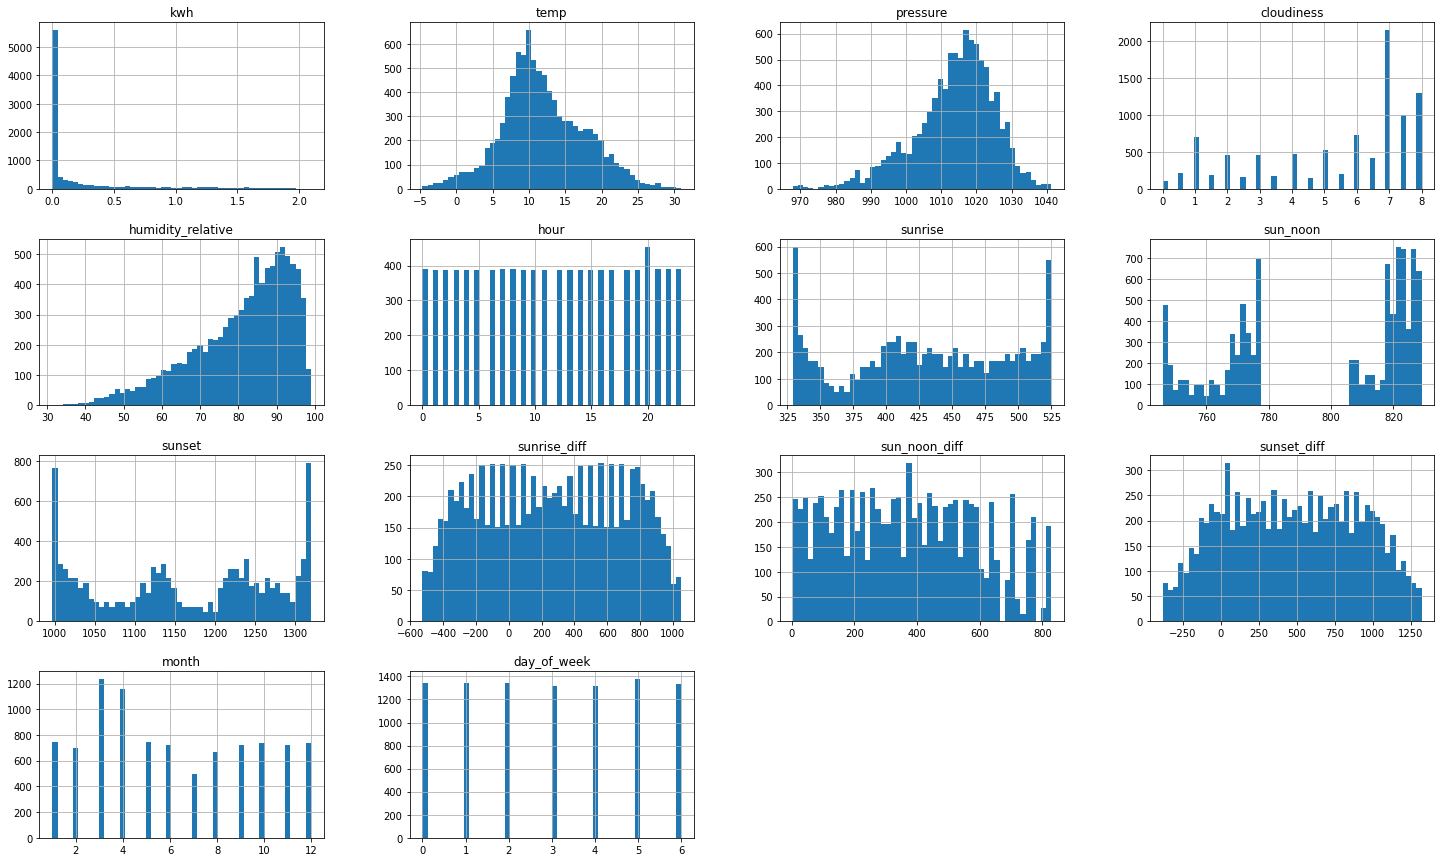

In [45]:
data.hist(bins=50, figsize=(25, 15))
plt.show()

Observations:
- kwh has a lot of 0 values
- month, day, hour and cloudiness are categorical

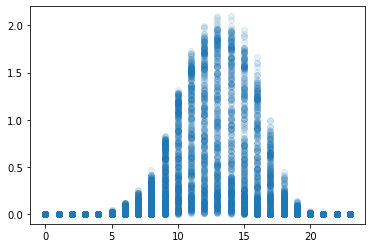

In [46]:
plt.scatter(data["hour"], data["kwh"], alpha=0.1)
plt.show()

Observation:
- kwh is clearly higher during the day

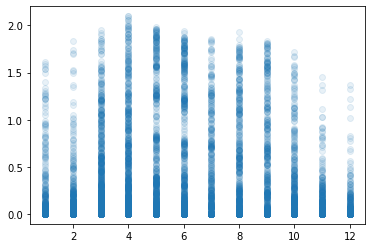

In [47]:
plt.scatter(data["month"], data["kwh"], alpha=0.1)
plt.show()

## Create a test set

In [47]:
X = data.drop(columns=["kwh"])
y = data["kwh"]

In [48]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((7504, 13), (1876, 13))

## Look for correlations

In [49]:
data = pd.concat([X_train, y_train], axis=1)

In [51]:
corr_matrix = data.corr(numeric_only=True)
corr_matrix["kwh"].sort_values(ascending=False).round(2)

kwh                  1.00
temp                 0.42
sunset               0.30
sun_noon             0.26
pressure             0.15
sunrise_diff         0.13
hour                 0.09
day_of_week         -0.01
sunset_diff         -0.01
month               -0.04
cloudiness          -0.27
sunrise             -0.28
sun_noon_diff       -0.60
humidity_relative   -0.64
Name: kwh, dtype: float64

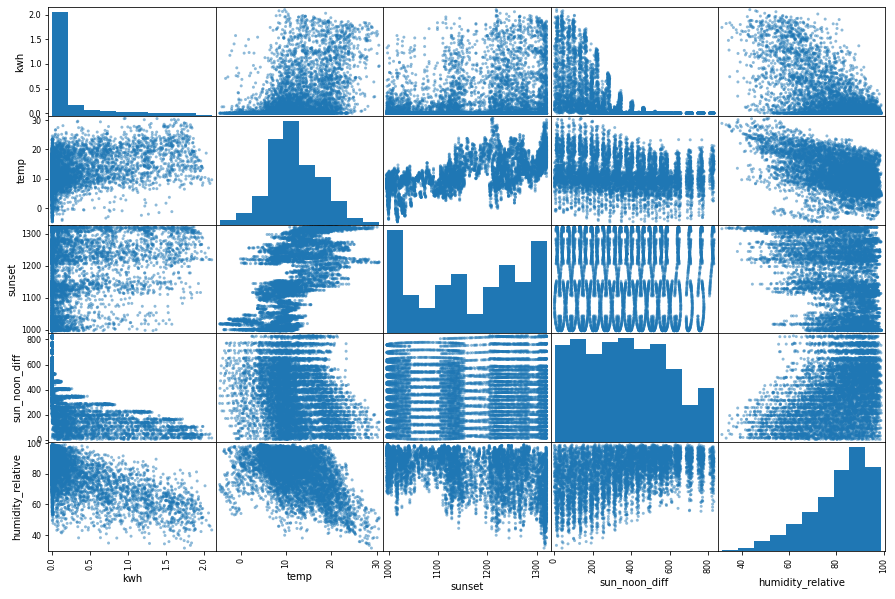

In [52]:
from pandas.plotting import scatter_matrix

attributes = ["kwh", "temp", "sunset", "sun_noon_diff", "humidity_relative"]
scatter_matrix(data[attributes], figsize=(15, 10))
plt.show()

## Prepare the data

In [53]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7504 entries, 8420 to 7595
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   temp               7504 non-null   float64
 1   pressure           7504 non-null   float64
 2   cloudiness         7504 non-null   float64
 3   humidity_relative  7504 non-null   float64
 4   hour               7504 non-null   int32  
 5   sunrise            7504 non-null   int64  
 6   sun_noon           7504 non-null   int64  
 7   sunset             7504 non-null   int64  
 8   sunrise_diff       7504 non-null   int64  
 9   sun_noon_diff      7504 non-null   int64  
 10  sunset_diff        7504 non-null   int64  
 11  month              7504 non-null   int64  
 12  day_of_week        7504 non-null   int64  
dtypes: float64(4), int32(1), int64(8)
memory usage: 791.4 KB


In [54]:
# give categorical values their own type
X_train["month"] = X_train["month"].astype("category")
X_train["day_of_week"] = X_train["day_of_week"].astype("category")
X_train["hour"] = X_train["hour"].astype("category")
# X_train["cloudiness"] = X_train["cloudiness"].astype("category")

In [55]:
data_num_ix = X_train.select_dtypes(include=[np.number]).columns
data_cat_ix = X_train.select_dtypes(include=["category"]).columns
print("Numerical columns: ", data_num_ix)
print("Categorical columns: ", data_cat_ix)

Numerical columns:  Index(['temp', 'pressure', 'cloudiness', 'humidity_relative', 'sunrise',
       'sun_noon', 'sunset', 'sunrise_diff', 'sun_noon_diff', 'sunset_diff'],
      dtype='object')
Categorical columns:  Index(['hour', 'month', 'day_of_week'], dtype='object')


In [56]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer

num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("standardize", StandardScaler())
])

# log_pipeline = Pipeline([
#     ("impute", SimpleImputer(strategy="median")),
#     ("log", FunctionTransformer(np.log, inverse_func=np.exp)),
#     ("standardize", StandardScaler())
# ])

cat_pipline = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")), 
    ("one_hot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessing = ColumnTransformer([
    ("num", num_pipeline, data_num_ix),
    ("cat", cat_pipline, data_cat_ix)
])

## Model selection

### Linear Regression

In [57]:
from sklearn.linear_model import LinearRegression
from sklearn.compose import TransformedTargetRegressor

sqrt_transformer = FunctionTransformer(np.sqrt, inverse_func=np.square)

lin_reg = Pipeline([
    ("preprocessing", preprocessing),
    ("lin_reg", TransformedTargetRegressor(LinearRegression(), transformer=sqrt_transformer))
])

lin_reg.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardize',
                                                                   StandardScaler())]),
                                                  Index(['temp', 'pressure', 'cloudiness', 'humidity_relative', 'sunrise',
       'sun_noon', 'sunset', 'sunrise_diff', 'sun_noon_diff', 'sunset_diff'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('one_hot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['hour', 'month', 'day_of_week'], dtype='object'))])),
                ('lin_reg',
                 TransformedTargetRegressor(regressor=LinearRegression(),
                                            transformer=FunctionTransformer(func=<ufunc 'sqrt'>,
                                                                            inverse_func=<ufunc 'square'>)))])

In [58]:
# cross validation for linear regression
from sklearn.model_selection import cross_val_score

scores = -cross_val_score(lin_reg, X_train, y_train, scoring="neg_mean_absolute_error", cv=10)
print("Linear Regression cross validation MAE: ", scores.mean())

Linear Regression cross validation MAE:  0.10548666675718535


In [59]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error

y_test_pred = lin_reg.predict(X_test)
rmse = root_mean_squared_error(y_test, y_test_pred)
mae = mean_absolute_error(y_test, y_test_pred)
print("Linear Regression RMSE on test set: ", rmse)
print("Linear Regression MAE on test set: ", mae)

Linear Regression RMSE on test set:  0.20933778414694615
Linear Regression MAE on test set:  0.10913351183945766


In [61]:
y_train_pred = lin_reg.predict(X_train)
mae = mean_absolute_error(y_train, y_train_pred)
print("Linear Regression RMSE on train set: ", mae)

Linear Regression RMSE on train set:  0.09295991092417458


In [62]:
def plot_predictions(y_test, y_pred, size):
    plt.figure(figsize=(12, 6))
    size_range = range(size)
    plt.plot(size_range, y_test[:size], label="Actual")
    plt.plot(size_range, y_pred[:size], label="Predicted")
    plt.legend()
    plt.show()

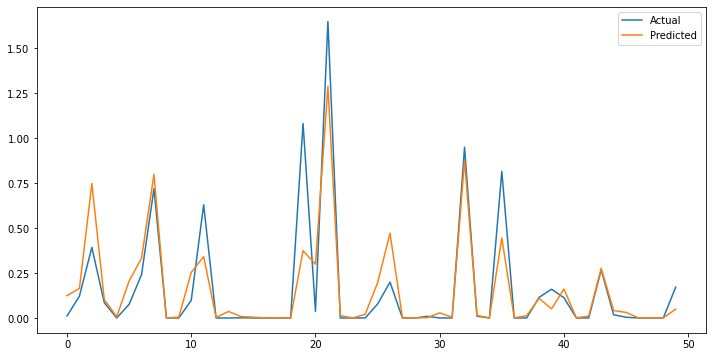

In [63]:
plot_predictions(y_test, y_test_pred, 50)

In [64]:
dump(lin_reg, "models/lin_reg.joblib")

['models/lin_reg.joblib']

In [65]:
# Learning curves

### Polynomial Regression

In [66]:
# Polynomial Regression with different degrees
from sklearn.preprocessing import PolynomialFeatures
from sklearn.base import clone

degrees = range(2, 7)
best_score = np.inf
best_degree = 0
poly_regs = {}

for degree in degrees:
    new_num_pipeline = clone(num_pipeline)
    poly_features = PolynomialFeatures(degree=degree)
    new_num_pipeline.steps.append(["poly_features", poly_features])
    new_preprocessing = ColumnTransformer([
        ("num", new_num_pipeline, data_num_ix),
        ("cat", cat_pipline, data_cat_ix)
    ])
    poly_reg = Pipeline([
        ("preprocessing", new_preprocessing),
        ("lin_reg", TransformedTargetRegressor(LinearRegression(n_jobs=-1), transformer=sqrt_transformer))
    ])
    scores = -cross_val_score(poly_reg, X_train, y_train, scoring="neg_mean_absolute_error", cv=5)
    print(f"Polynomial Regression degree {degree} cross validation MAE: ", scores.mean())
    poly_reg.fit(X_train, y_train)
    poly_regs[f"poly_reg_{degree}"] = poly_reg
    y_train_pred = poly_reg.predict(X_train)
    mae = mean_absolute_error(y_train, y_train_pred)
    print(f"Polynomial Regression degree {degree} MAE on training set: ", mae)
    y_test_pred = poly_reg.predict(X_test)
    mae = mean_absolute_error(y_test, y_test_pred)
    print(f"Polynomial Regression degree {degree} MAE on test set: ", mae)
    if scores.mean() < best_score:
        best_score = scores.mean()
        best_degree = degree

print("Best degree for polynomial regression: ", best_degree)

Polynomial Regression degree 2 cross validation MAE:  0.06944229075926484
Polynomial Regression degree 2 MAE on training set:  0.06831929145543449
Polynomial Regression degree 2 MAE on test set:  0.0731647889574554
Polynomial Regression degree 3 cross validation MAE:  0.0636291364722512
Polynomial Regression degree 3 MAE on training set:  0.060598320248453776
Polynomial Regression degree 3 MAE on test set:  0.06473159244142804
Polynomial Regression degree 4 cross validation MAE:  0.059222409896204975
Polynomial Regression degree 4 MAE on training set:  0.05043140311791069
Polynomial Regression degree 4 MAE on test set:  0.06077518808714437
Polynomial Regression degree 5 cross validation MAE:  0.06956157580556063
Polynomial Regression degree 5 MAE on training set:  0.037319624648301894
Polynomial Regression degree 5 MAE on test set:  0.06356216437743022
Polynomial Regression degree 6 cross validation MAE:  100.4967855195788
Polynomial Regression degree 6 MAE on training set:  0.01136959

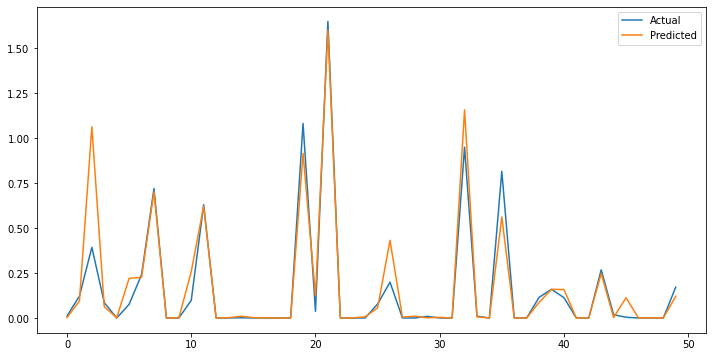

In [67]:
poly_reg = poly_regs[f"poly_reg_{best_degree}"]
plot_predictions(y_test, poly_reg.predict(X_test), 50)

In [68]:
dump(poly_reg, "models/poly_reg.joblib")

['models/poly_reg.joblib']

### Random Forest

In [72]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = Pipeline([
    ("preprocessing", preprocessing),
    ("forest_reg", RandomForestRegressor(n_jobs=-1, random_state=42))
])

forest_reg.fit(X_train, y_train)

scores = -cross_val_score(forest_reg, X_train, y_train, scoring="neg_mean_absolute_error", cv=5)
print("Random Forest cross validation MAE: ", scores.mean())

y_test_pred = forest_reg.predict(X_test)
mae = mean_absolute_error(y_test, y_test_pred)
print("Random Forest MAE on test set: ", mae)

Random Forest cross validation MAE:  0.05925191595816205
Random Forest MAE on test set:  0.06042512985074246


In [73]:
y_train_pred = forest_reg.predict(X_train)
mae = mean_absolute_error(y_train, y_train_pred)
print("Random Forest MAE on train set: ", mae)

Random Forest MAE on train set:  0.021565054206011108


In [74]:
from sklearn.model_selection import GridSearchCV

forest_reg = Pipeline([
    ("preprocessing", preprocessing),
    ("forest_reg", RandomForestRegressor(random_state=42, n_jobs=-1))
])

param_grid = [
    {
        "forest_reg__n_estimators": [100, 150, 200], 
        "forest_reg__max_features": [20, 40],
        "forest_reg__max_depth": [20, 30, 40],
        "forest_reg__bootstrap": [True, False]
    },
]

grid_search = GridSearchCV(forest_reg, param_grid, cv=3, scoring="neg_mean_absolute_error")
grid_search.fit(X_train, y_train)

print("Random Forest best parameters: ", grid_search.best_params_)
print("Random Forest best score: ", -grid_search.best_score_)

Random Forest best parameters:  {'forest_reg__bootstrap': False, 'forest_reg__max_depth': 20, 'forest_reg__max_features': 20, 'forest_reg__n_estimators': 200}
Random Forest best score:  0.05946728778234675


In [75]:
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_forest_reg__bootstrap,param_forest_reg__max_depth,param_forest_reg__max_features,param_forest_reg__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
20,8.269057,0.739420,0.179407,0.029971,False,20,20,200,"{'forest_reg__bootstrap': False, 'forest_reg__...",-0.058664,-0.059286,-0.060452,-0.059467,0.000741,1
32,7.881240,0.121958,0.146615,0.007775,False,40,20,200,"{'forest_reg__bootstrap': False, 'forest_reg__...",-0.058920,-0.059438,-0.060449,-0.059602,0.000635,2
26,7.008823,0.663420,0.202567,0.031084,False,30,20,200,"{'forest_reg__bootstrap': False, 'forest_reg__...",-0.058938,-0.059496,-0.060445,-0.059626,0.000622,3
19,6.372003,0.267055,0.118110,0.015503,False,20,20,150,"{'forest_reg__bootstrap': False, 'forest_reg__...",-0.058886,-0.059171,-0.060867,-0.059641,0.000875,4
31,5.878351,0.220657,0.180104,0.024216,False,40,20,150,"{'forest_reg__bootstrap': False, 'forest_reg__...",-0.059193,-0.059735,-0.060716,-0.059881,0.000630,5


In [76]:
model = grid_search.best_estimator_
feature_importances = model["forest_reg"].feature_importances_
sorted(zip(feature_importances, model["preprocessing"].get_feature_names_out()), reverse=True)

[(0.33011143941778065, 'num__sun_noon_diff'),
 (0.2282966190375121, 'num__humidity_relative'),
 (0.09078375239653043, 'num__sunset_diff'),
 (0.09046915003952163, 'num__cloudiness'),
 (0.050369720984434076, 'num__temp'),
 (0.04168061488183474, 'num__sunrise_diff'),
 (0.0294836527997527, 'num__sunrise'),
 (0.02853942782071537, 'num__sunset'),
 (0.019036509306042414, 'num__pressure'),
 (0.018576272964116226, 'num__sun_noon'),
 (0.011666475897436503, 'cat__hour_9'),
 (0.010150959392661252, 'cat__hour_13'),
 (0.007909987713481883, 'cat__hour_12'),
 (0.006343000830517106, 'cat__hour_17'),
 (0.005669458567914177, 'cat__hour_11'),
 (0.004670933671278719, 'cat__hour_10'),
 (0.0021450560472740707, 'cat__hour_14'),
 (0.0019329056165198022, 'cat__hour_8'),
 (0.0017996720095124783, 'cat__hour_16'),
 (0.001584448630087487, 'cat__day_of_week_3'),
 (0.001488405097441476, 'cat__month_3'),
 (0.001425209205299331, 'cat__day_of_week_2'),
 (0.001403662741925606, 'cat__month_5'),
 (0.0013329377789864265, 'c

In [77]:
model = grid_search.best_estimator_
y_test_pred = model.predict(X_test)
rmse = root_mean_squared_error(y_test, y_test_pred)
mae = mean_absolute_error(y_test, y_test_pred)
print("Random Forest RMSE on test set: ", rmse)
print("Random Forest MAE on test set: ", mae)

Random Forest RMSE on test set:  0.13134847479535056
Random Forest MAE on test set:  0.05822209452202574


In [78]:
preds = model.predict(X_train)
mae = mean_absolute_error(y_train, preds)
print("Random Forest RMSE on train set: ", mae)

Random Forest RMSE on train set:  0.0007836635077457393


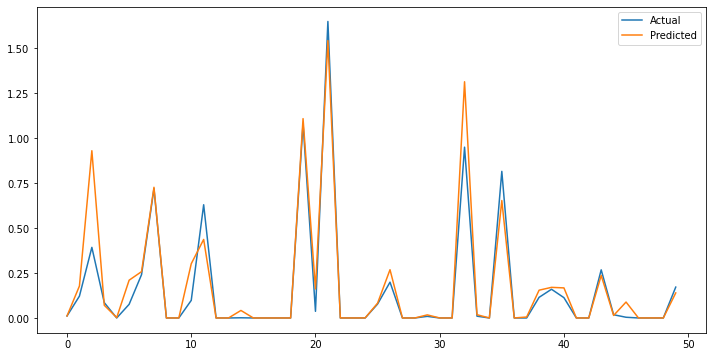

In [83]:
plot_predictions(y_test, y_test_pred, 50)

In [82]:
dump(model, "models/random_forest.joblib")

['models/random_forest.joblib']

### LinearSVR

In [81]:
from sklearn.svm import LinearSVR

svm_reg = Pipeline([
    ("preprocessing", preprocessing),
    ("svm_reg", TransformedTargetRegressor(LinearSVR(random_state=42, dual="auto", max_iter=1000000)))
])

param_grid = [
    {"svm_reg__regressor__C": [0.5, 1, 2], "svm_reg__regressor__epsilon": [0.05, 0.1, 0.5]}
]

grid_search = GridSearchCV(svm_reg, param_grid, cv=5, scoring="neg_mean_absolute_error")
grid_search.fit(X_train, y_train)

print("SVM best parameters: ", grid_search.best_params_)
print("SVM best MAE score: ", -grid_search.best_score_)

SVM best parameters:  {'svm_reg__regressor__C': 2, 'svm_reg__regressor__epsilon': 0.05}
SVM best MAE score:  0.14755578783965928


### SVR

In [358]:
from sklearn.svm import SVR

degree = 3

svr = Pipeline([
    ("preprocessing", new_preprocessing),
    ("svr", TransformedTargetRegressor(SVR(kernel="poly", degree=degree), transformer=sqrt_transformer))
])
param_grid = [
    {"svr__regressor__C": [0.1, 1, 10], "svr__regressor__epsilon": [0.1, 1, 10]}
]
grid_search = GridSearchCV(svr, param_grid, cv=5, scoring="neg_root_mean_squared_error")
grid_search.fit(X_train, y_train)
model = grid_search.best_estimator_
score = -grid_search.best_score_
print(f"SVR poly degree {degree} best parameters: ", grid_search.best_params_)
print(f"Polynomial Regression degree {degree} cross validation RMSE: ", score)
y_train_pred = model.predict(X_train)
rmse = root_mean_squared_error(y_train, y_train_pred)
print(f"Polynomial Regression degree {degree} RMSE on training set: ", rmse)
y_test_pred = poly_reg.predict(X_test)
rmse = root_mean_squared_error(y_test, y_test_pred)
print(f"Polynomial Regression degree {degree} RMSE on test set: ", rmse)
